<div style="border: 1px solid lightgray; padding: 10px; background-color: #f9f9f9;">

<font size=1>

    Summer School for AstroStatistics in Crete, 2025

The content presented in this notebook is the original work of the authors, unless specified otherwise.
Any publicly available material incorporated is properly credited to its respective sources.
All references to published papers, datasets, and software tools are duly acknowledged.
The original content of this notebook is licensed under the GNU General Public License v3.0 (GNU GPLv3).
</font>
</div>

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import emcee
import corner
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<font size=6>**MARKOV CHAIN MONTE CARLO: Basics**</font>


# 1. Introduction

## 1.1 Challenges in Bayesian inference

In the previous sessions we saw examples of parameter estimation for models of one parameter. We also estimated uncertainties, but this required a lot of steps. In this session we will see a general method that can be applied to both simple and complex models, able to naturally provide uncertainties.

*  ### Challenge 1: multiple parameters $\equiv$ multiple dimensions

If our model has many parameters, $\theta_1, \theta_2, \cdots, \theta_k$, then the posterior is a $k$-dimensional function.

$$ P(\theta_1, \theta_2, \cdots, \theta_k | \mathrm{Data}) $$

Finding the maximum of a $k$-D function is...way harder than in the 1-D or 2-D cases. Chances are that there are also multiple modes, which may not be found by many optimization algorithms.

We could try to compute the posterior in a $k$-dimensional **grid** and select the point with the highest posterior. Though, a complex function might have narrow peaks - a high resolution grid might be necessary. The higher the resolution and the number of dimensions, the higher number of evaluations of the posterior - making the computation extremely time consuming.

*  ### Challenge 2: uncertainties

Maximizing the posterior provides an estimate of the parameter but not its uncertainty. There are approximate solutions to get an estimate of the uncertainty on the parameter, but they usually make an assumption about the shape of the posterior (e.g. Gaussian peak).

*  ### Challenge 3: brute-force is non-optimal...

Another complication with grids is that we may spend a lot of time at regions of the parameter space where the posterior is low. Instead, we would like to spend more time around the peaks, the regions of high posterior probability.

![Mishra's Bird function](images/testfunc.png)


## 1.2 A solution through sampling

The posterior distribution is given by Bayes' theorem:

$$
p(\theta \mid \mathbf{y}) = \frac{p(\mathbf{y} \mid \theta) \, p(\theta)}{p(\mathbf{y})}
$$

where:

- $\theta$ represents the parameters we want to estimate,
- $\mathbf{y}$ represents the observed data,
- $p(\theta)$ is the prior distribution reflecting our beliefs about $\theta$ before seeing the data,
- $p(\mathbf{y} \mid \theta)$ is the likelihood, the probability of observing the data given parameters $\theta$,
- $p(\mathbf{y})$ is the marginal likelihood or evidence, a normalizing constant ensuring the posterior sums to 1.

The evidence (marginal likelihood) is given by:

$$
p(\mathbf{y}) = \int p(\mathbf{y} \mid \theta) \, p(\theta) \, d\theta
$$

where it is the total probability of observing the data, integrating over all possible parameter values.

**Challenge**: This integral is usually high-dimensional, non-analytical, or computationally expensive — especially for complex models.

Instead of computing $p(\theta \mid \mathbf{y})$ exactly, with sampling we can use the ratios of posterior values, so the normalizing constant cancels out. 

###  Problem: how to sample from a posterior?

# 2. The Markov Chain Monte Carlo technique

The Marcov Chain Monte Carlo (MCMC) is a widely used technique to sample from probability distributions, and therefore likelihoods or posteriors.

It is based on the idea of creating a chain of points in the parameter space, using a combination of (i) random walk and (ii) selection of points based on their relative probability.

An algorithm is used to ensure that the chain will reach **equilibrium**: after a number of steps (or length of the Markov chain) the chain will contain points that follow the same distribution, the **target distribution**.

> It is often characterized as one of the most influencial algorithms of the 20th century...

## 2.1 Metropolis-Hastings algorithm

We will discuss the Metropolis-Hastings algorithm, but note that there are *many* others out there. Here are the steps:

1. We start with one set of parameters $\theta_1$. 

    - In our case, $\theta_1$ is simply $\alpha$ since we have only one parameter in our model.
    
    - In general, $\theta_1$ can be a vector of 1, 5, or even a million separate parameters.
    
    This first value starts our Markov chain.
      
2. Using **some method** we obtain a new trial set of parameters $\theta_2$. *A proposition for a new position...*
    
    - It is important that this set is chosen randomly, but based on the previous set.
    - The dependence on only the previous set, is an essential property of a *Markov chain*.
    - The randomness is where the *Monte Carlo* in MCMC comes from.
    - The simplest method to obtain our new parameter values will be to add some random (Gaussian?) noise to our current value: $\theta_2 = \theta_1 + \epsilon$. This is also called **step size**. You typically want to tune the step size, $\epsilon$, to optimize the process for a given problem.
    
3. Now, we want to calculate and compare the posterior probabilities for both $\theta_1$ and $\theta_2$. If the new parameter is better than the current one,

    $$ P(\theta_2) > P(\theta_1) $$
    we always move the chain to $\theta_2$. If not, we *might* move to $\theta_2$ with probability equal to the ratio
    $$ \frac{P(\theta_2)}{P(\theta_1)}$$
    In practice, we draw a random number from a uniform distribution between 0 and 1. If that random number is less than the ratio, we move the chain to $\theta_2$. Else, we stay at $\theta_1$ for another iteration.

4. Now that we have our new value for $\theta$, we return to step 2 and repeat for as many iterations as we want. Often this is in the thousands or more.

![Metropolis-Hastings algorithm creating a Markov Chain. From [2]](images/mh.png)

## 2.2 Let's implement the M-H algorithm...

In [2]:
def metro_hastings(ln_posterior, theta_0, N_steps, step_size=0.2, args=[], verbose=True):
    """Metropolis-Hastings algorith for sampling a posterior distribution of one parameter.

    Parameters
    ----------
    ln_posterior : function that returns the logarithm of the posterior
    theta_0      : initial guess for the model parameter
    N_steps      : the length of the Markov Chain that will be returned
    step_size    : the standard deviation of the normally distributed step size
    args         : additional arguments to be passed to the posterior function
    
    Returns
    -------
    A numpy array containing the Markov Chain.
    
    """
    chain = np.zeros(N_steps)                       # create the chain
    chain[0] = theta_0                              # store the initial point...
    if verbose:
        print(f"{chain[0]:.3g}", end=",")   # ...and print it!
    
    # hold the current value of the posterior to avoid recomputing it if position is not changed
    curr_P = ln_posterior(theta_0, *args)
    
    # populate the rest of the points in the chain
    for i in range(N_steps - 1):
        new_theta = chain[i] + np.random.normal(scale=step_size) #Draw random samples from a normal (Gaussian) distribution.
        new_P = ln_posterior(new_theta, *args)
        
        # should we move to the new position?
        if (new_P > curr_P) or (np.random.rand() < np.exp(new_P - curr_P)):
            # if yes... store the new value, print it and update the 'current posterior'
            chain[i + 1] = new_theta
            if verbose:
                print(f"{new_theta:.3g}", end=", ")
            curr_P = new_P
        else:
            # if not... store again the current position and print a '.'
            chain[i + 1] = chain[i]
            if verbose:
                print(".", end=" ")
            
    return chain

## 2.3 The data

When massive stars ($> 8 M_\odot$) reach the ends of their lives, they form neutron stars (NS) or black holes. Newly formed NSs receive "kicks" with velocities typically in the range 100-500 km/s. One distribution that matches these kind of velocities is the **Maxwellian** as it has been shown by studies of pulsars (e.g., Hobbs et al. 2006, MNRAS, 360, 974).

Note that the Maxwellian distribution (i.e., Maxwellian-Boltzmann from Statistical Mechanics) has one parameter, $a$ that sets the magnitude of the velocities (note that $a$ is not the mean nor the mode):

$$ \Large
            f(x; a) = \sqrt{\dfrac{2}{\pi}} \frac{x^2}{a^3} \exp\left({-\frac{x^2}{2a^2}}\right)
$$

In the following example we create an artificial dataset:

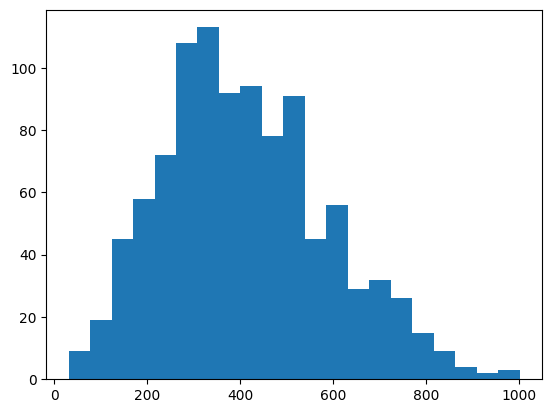

In [3]:
def make_velocity_sample(a1, a2, f, N):
    """Make a NS kick velocity distribution using two Maxwellian components and their relative contribution.
    
    a1 = the scale parameter of the electron-capture supernovae (ECSN) kick velocity distribution
    a2 = the scale parameter of the core-collapse supernovae (CCSN) kick velocity distribution
     f = the fraction of NSs formed by ECSN
     N = the sample size   
    """
    N_ECSN = st.binom(N, f).rvs() #
    N_CCSN = N - N_ECSN
    
    # the two kick velocity distributions
    distribution_ECSN = st.maxwell(scale=a1)
    distribution_CCSN = st.maxwell(scale=a2)
    # make samples from both distributions and join them
    sample = np.concatenate([distribution_ECSN.rvs(size=N_ECSN), distribution_CCSN.rvs(size=N_CCSN)])
    # shuffle the array to make sure we cannot distinguish the two samples anymore
    np.random.shuffle(sample)
    return sample
    
    
a = 265.0 # "width" of the distribution
N = 1000

sample_1 = make_velocity_sample(a, a, 0.0, N=N)
plt.figure()
plt.hist(sample_1, bins="fd")
plt.show()

## 2.4 Defining the posterior for our problem

For **prior** we use a uniform one that allows only positive values.

For the **log-likelihood** we use directly the `scipy.maxwell.logpdf` function. Note that `scipy` provides the `log` versions of distribution functions for better accuracy when dealing with small numbers.

In [4]:
def ln_prior(a):
    return -np.inf if a <= 0 else 0.0

def datum_ln_likelihood(v, a):
    return st.maxwell.logpdf(v, scale=a)

def ln_likelihood(velocities, a):
    return np.sum(datum_ln_likelihood(velocities, a))

def ln_posterior(a, velocities):
    result = ln_prior(a) + ln_likelihood(velocities, a)
    return -np.inf if np.isnan(result) else result

## 2.5 Running the M-H algorithm

In [5]:
"""Metropolis-Hastings algorith for sampling a posterior distribution of one parameter.

    Parameters
    ----------
    ln_posterior : function that returns the logarithm of the posterior
    theta_0      : initial guess for the model parameter
    N_steps      : the length of the Markov Chain that will be returned
    step_size    : the standard deviation of the normally distributed step size
    args         : additional arguments to be passed to the posterior function
    
    Returns
    -------
    A numpy array containing the Markov Chain.
    
"""
alpha_0 = 400.0   # our initial guess
step_size = 10    # a step size that is "appropriate"

chain = metro_hastings(ln_posterior, alpha_0, args=[sample_1], 
                       step_size=step_size, N_steps=500)

400,396, 388, . 381, 350, 347, . . 343, . 327, 325, . . 324, 303, . . 288, 274, . . . 267, . 258, 264, . 256, . 258, . 257, 259, . . 257, 255, . 266, . . . 264, . . . . 261, . . . . . 258, . 260, . . 266, . . . 261, 260, . . 262, 259, 261, 252, . . 250, . . . 251, 256, . 260, . . . 257, . . 258, 261, 261, 257, 258, . . . . . . 257, . . . 256, . . . 256, . 263, 264, 258, . . 264, 264, . . . 259, . . 264, . . 266, 261, . 264, 260, . 260, . . 259, . 260, 257, . 258, . 256, . 257, . . . 264, . . . 262, 260, . . . 257, . . 262, 256, . . . . . 259, 258, 258, . . 261, 264, 253, 252, 256, . 261, 259, 259, . . 257, . 257, . . . 257, 260, . . . . . 263, . . . . 256, 260, . . 254, . 255, 260, . 262, 264, . 254, 253, . 265, 264, . . 264, . 252, 254, . . . 263, . . . . . . . 260, . . 261, 261, . . . . 258, . . . 257, 261, . 261, . 261, . 259, 261, . 262, 256, . 261, . . 257, 260, 258, 264, 263, . 262, 262, . . 271, . . . . 262, 255, . 257, . . 259, . . . . 255, 265, 260, 260, . . 255, 263, . . 263,

## 2.6 The produced Markov Chain and the *burn-in* phase

The first steps in the chain are not in the optimal regime. This is called the "burn-in" and is thrown away. In principle, there is no absolute way to determine if your chains have converged to the optimal region of parameter space. In practice, unless your problem is pathological, it is usually pretty obvious. Do remember this can be an issue and take care of it!

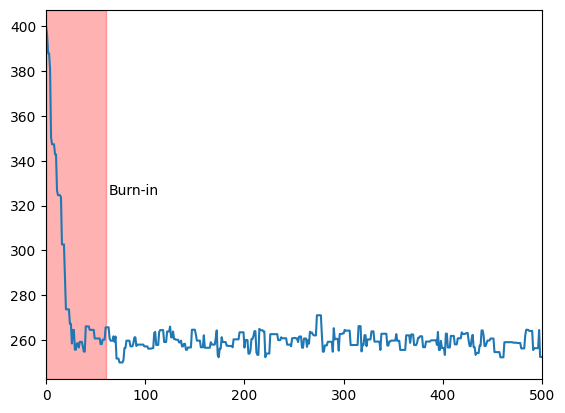

In [6]:
n_burnin = 60   # change this value if needed

plt.figure()
plt.axvspan(0, n_burnin, color="r", alpha=0.3)
plt.plot(chain)
_, _, y_min, y_max = plt.axis()
plt.text(n_burnin + 3, (y_min + y_max) / 2.0, "Burn-in")
chain_converged = chain[n_burnin:]
plt.xlim(0,len(chain))
plt.show()

## 2.7 The acceptance fraction

The acceptance fraction depends on the target distribution. It has been shown that for one-dimensional Gaussian distributions, the optimal acceptance fraction is 50%, while for high dimensional Gaussian distributions is 23.4% [1].

[1]  A. Gelman. W. R. Gilks. G. O. Roberts. "Weak convergence and optimal scaling of random walk Metropolis algorithms." Ann. Appl. Probab. 7 (1) 110 - 120, February 1997. https://doi.org/10.1214/aoap/1034625254 

In [7]:
accepted = np.diff(chain_converged) != 0
print(f"Acceptance fraction: {np.mean(accepted):.3f}")

Acceptance fraction: 0.410


### Our acceptance fraction might be low or high. If that's the case, what can we do to improve this?

<div class="alert alert-danger" role="alert" style="border-radius: 8px; padding: 10px;">
<details>

<b><summary>[Spoiler] (click here to expand)</summary></b>  

Very small or large acceptance fraction indicates that the step size is not appropriate and the algorithm struggles to reach to the target distribution. By tuning the step size, $\epsilon$, we can optimize the procedure. This might affect the length of the burn-in phase.
    <br>
    >0.5 chain takes small steps, try larger step size
    <br>
    <0.2 steps too big, try smaller step size
</details>
</div>


## 2.8 Reporting results in the $m \pm s$ form or with confidence intervals

Now, we can plot the posterior distribution of $\alpha$ to obtain our final result.

  mean +/- std |  259.386 +/- 3.491
median +hi -lo |  259.259 +3.596 -2.970


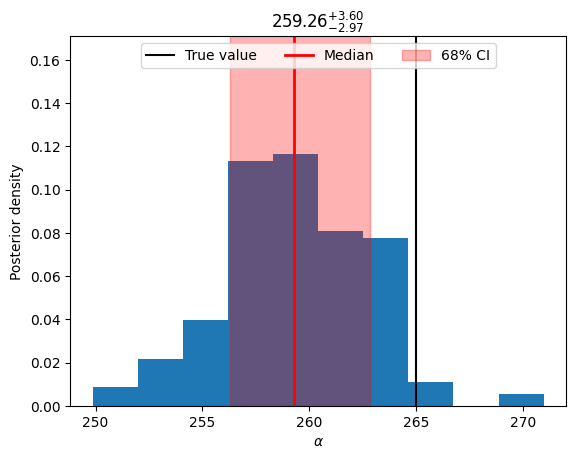

In [8]:
mean, std = np.mean(chain_converged), np.std(chain_converged)
lo68, median, hi68 = np.percentile(chain_converged, [16, 50, 84])

print("  mean +/- std |  {:.3f} +/- {:.3f}".format(mean, std))
print("median +hi -lo |  {:.3f} +{:.3f} -{:.3f}".format(
    median, hi68 - median, median - lo68))


plt.figure()
plt.hist(chain_converged, bins=10, density=True)
_, _, _, y_max = plt.axis()
plt.ylim(ymax=y_max*1.4)

plt.axvline(a, color="k", label="True value")
plt.axvline(median, color="r", linewidth=2, label="Median")
plt.axvspan(lo68, hi68, color="r", alpha=0.3, label="68% CI")
plt.title(r"${:.2f}^{{+{:.2f}}}_{{-{:.2f}}}$".format(median, hi68 - median, median - lo68))
plt.xlabel(r"$\alpha$")
plt.ylabel("Posterior density")
plt.legend(loc="upper center", ncol=3)
plt.show()

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">
    


# Exercise 1: effect of initial position

Run the MCMC for three different initial positions.

<font size=3><u>**Does the initial position affect the result?**</u><font>

</div>

<div class="alert alert-danger" role="alert" style="border-radius: 8px; padding: 10px;">
<details>

<b><summary>[Spoiler] (click here to expand)</summary></b>  

It doesn't! The chains converge to the same solution but it may take a while if we start away from it!

</details>
</div>

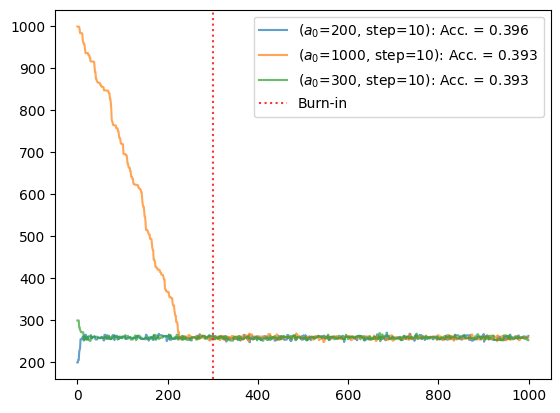

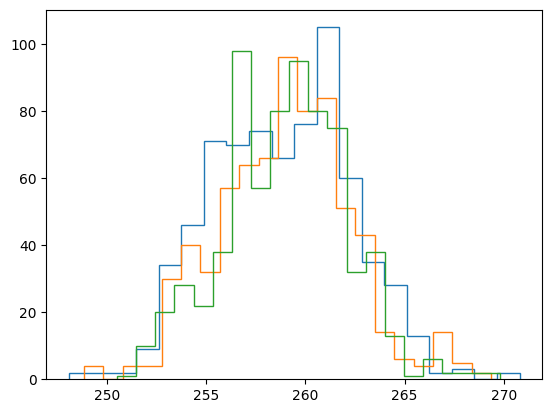

In [10]:
step_size = 10.0                   # our step size

alpha_0s = [200,1000,300]         # pick the initial guesses
step_sizes = [step_size] * 3       # the step sizes

N_steps = 1000
n_burnin = 300   # pick a value that is "safe" for all chains

# make all chains
chains = [metro_hastings(ln_posterior, alpha_0, args=[sample_1], step_size=step_size, N_steps=N_steps, verbose=False)
          for alpha_0, step_size in zip(alpha_0s, step_sizes)]
converged_chains = [chain[n_burnin:] for chain in chains]

# plot the chains and samples
plt.figure()
for alpha_0, step_size, chain, converged_chain in zip(alpha_0s, step_sizes, chains, converged_chains):
    acceptance_fraction = np.mean(converged_chain[:-1] != converged_chain[1:])
    plt.plot(chain, alpha=0.7, label=f"($a_0$={alpha_0:.6g}, step={step_size:.6g}): Acc. = {acceptance_fraction:.3f}")
plt.axvline(n_burnin, color="r", ls=":", alpha=0.8, label="Burn-in")
plt.legend(loc="upper right")
plt.show()

plt.figure()
for alpha_0, step_size, converged_chain in zip(alpha_0s, step_sizes, converged_chains):
    plt.hist(converged_chain, bins="fd", histtype="step")
plt.show()

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">

# Exercise 2: effect of step size

Now try with the same initial guess (away for the solution, e.g., 400), but with different step sizes.

<font size=3><u>**How does the step size affect the convergence and result?**</u><font>

</div>

<div class="alert alert-danger" role="alert" style="border-radius: 8px; padding: 10px;">
<details>

<b><summary>[Spoiler] (click here to expand)</summary></b>  

  The larger the step, the quicker we explore the parameter space and find the solution. However, this makes it harder to go to newly proposed positions and we are not efficiently sampling the posterior (small acceptance fraction). 
  With very small step sizes the convergence is so slow that the burn-in phase lasts for long, but we can't "lose" the solution. However, the acceptance fraction is too large: we are not efficiently exploring the space around the solution - it seems like a random walk around it.       Thus, we may need very long chains to converge to the correct posterior distribution. 
  Intermediate step sizes are optimal: quick convergence, good sampling of the posterior, acceptance fraction in the desired range.

</details>
</div>

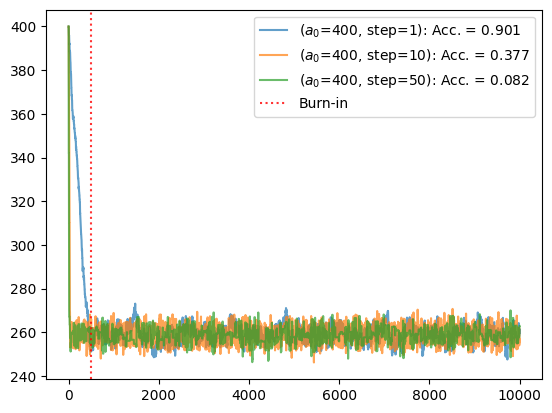

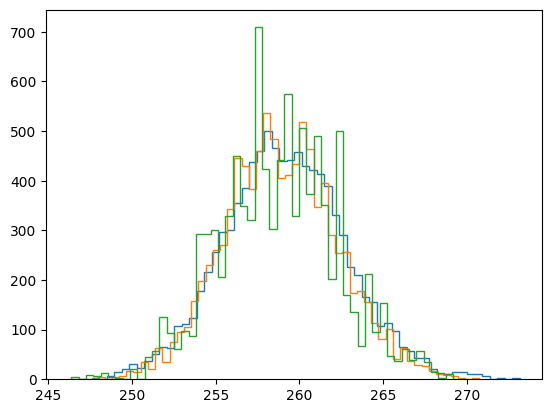

In [13]:
initial_position = 400.0           # pick an initial position away from the solution
alpha_0s = [initial_position] * 3  
step_sizes = [1, 10, 50]    # pick the step sizes

N_steps = 10000
n_burnin = 500   # pick a value that is "safe" for all chains

# make all chains
chains = [metro_hastings(ln_posterior, alpha_0, args=[sample_1], step_size=step_size, N_steps=N_steps, verbose=False)
          for alpha_0, step_size in zip(alpha_0s, step_sizes)]
converged_chains = [chain[n_burnin:] for chain in chains]

# plot the chains and samples
plt.figure()
for alpha_0, step_size, chain, converged_chain in zip(alpha_0s, step_sizes, chains, converged_chains):
    acceptance_fraction = np.mean(converged_chain[:-1] != converged_chain[1:])
    plt.plot(chain, alpha=0.7, label=f"($a_0$={alpha_0:.6g}, step={step_size:.6g}): Acc. = {acceptance_fraction:.3f}")
plt.axvline(n_burnin, color="r", ls=":", alpha=0.8, label="Burn-in")
plt.legend(loc="upper right")
plt.show()

plt.figure()
for alpha_0, step_size, converged_chain in zip(alpha_0s, step_sizes, converged_chains):
    plt.hist(converged_chain, bins="fd", histtype="step")
plt.show()

# 3. The MCMC module `emcee`:


There are various MCMC algorithms (or samplers) out there. One very good algorithm that does not require much tuning is Goodman & Weare’s Affine Invariant Markov chain Monte Carlo Ensemble Sampler [3], with a Python implementation: the `emcee` module.

## Multiple chains/walkers (ensemble)

A walker might fail due to an "unfortunate" initial position. By having many of them we might explore the parameter space more efficiently. Typical choices: 100 or 1000. `emcee` does this for us.

## Implementation of the *stretch* move

The different "chains" might "talk" to each other to help convergence! We will see that in an example later.

## Parallelization

`emcee` supports parallel computing, and therefore we can exploit the full potential of our machines or computer clusters. This is useful for large datasets, or complex likelihood functions (e.g., Kouroumpatzakis et al. 2020 [4]). 

# 4. Using `emcee`

## 4.1 Setting the `emcee` sampler

We need to set the number of "walkers", the number of steps that each walker will take, as well as the initial positions (typically randomly selected, but you can start from the same point as well).

In [28]:
n_walkers = 50
n_dim = 1
n_steps = 500

a_min = 10.0
a_max = 800.0

# set the parameter's initial positions
a_initial = np.random.uniform(a_min, a_max, size=n_walkers)

# take the initial values for each parameter and put them in columns of a 2D array
p0 = np.array([a_initial]).T

sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, 
                                log_prob_fn=ln_posterior, args=[sample_1],
                                moves=emcee.moves.GaussianMove(30.0))

## 4.2 Sampling from the posterior

In [29]:
result = sampler.run_mcmc(p0, nsteps=n_steps, progress=True)
print(sampler.chain.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 348.14it/s]

(50, 500, 1)


Let's inspect the output. There are three dimenions:

$$\large 
    \left(\text{# of walkers}\right) \times 
    \left(\text{# of steps}\right) \times
    \left(\text{# of dimensions}\right)
$$

## 4.3 Inspecting the chains

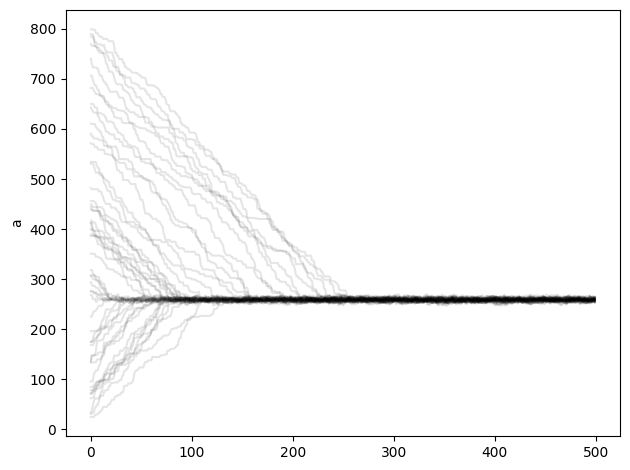

In [30]:
plt.figure()
for param_i in range(n_dim):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel("a" if param_i == 0 else "b")
    for j in range(n_walkers):
        chain = sampler.chain[j, :, param_i]
        plt.plot(chain, "k-", alpha=0.1)
plt.tight_layout()
plt.show()

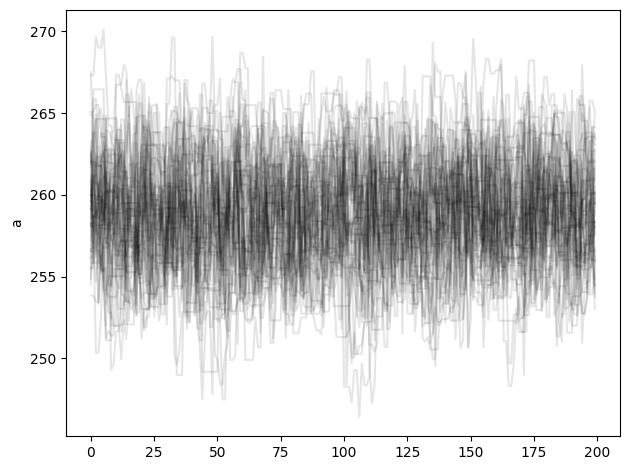

In [31]:
#removing the burn-in phase
n_burnin = 300

plt.figure()
for param_i in range(n_dim):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel("a" if param_i == 0 else "b")
    for j in range(n_walkers):
        chain = sampler.chain[j, n_burnin:, param_i]
        plt.plot(chain, "k-", alpha=0.1)
plt.tight_layout()
plt.show()

## 4.5 Corner plot of all the samples from the converged chains

Converged chain shape      : (50, 200, 1)
Converged flat chain shape : (10000, 1)


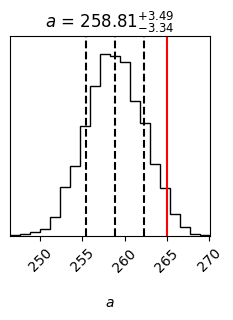

In [32]:
converged_chain = sampler.chain[:, n_burnin:, :]
print("Converged chain shape      :", converged_chain.shape)

flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)
print("Converged flat chain shape :", flat_converged_chain.shape)

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[a],
                    truth_color="r",
                    labels=[r"$a$", r"$b$"],
                    show_titles=True
                   )

# 5. The stretch move of `emcee`

When we have multiple walkers, we can exploit their distribution in the parameter space to explore it at an optimal scale. Essentially, a move from a walker at position $X_j$ can be at the direction of another walker $X_k$, with a step equal to the distance of the walkers times a factor that is randomly sampled in the range $(1/Z, Z)$ where $Z$ is the *stretch factor* which is by default $2.0$ in `emcee`. The theroy behind this move, including its compatibility with the Metropolis-Hastings algorithm can be found in  Goodman & Weare 2010 (https://msp.org/camcos/2010/5-1/p04.xhtml).

![title](images/stretch_move.png)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 329.91it/s]


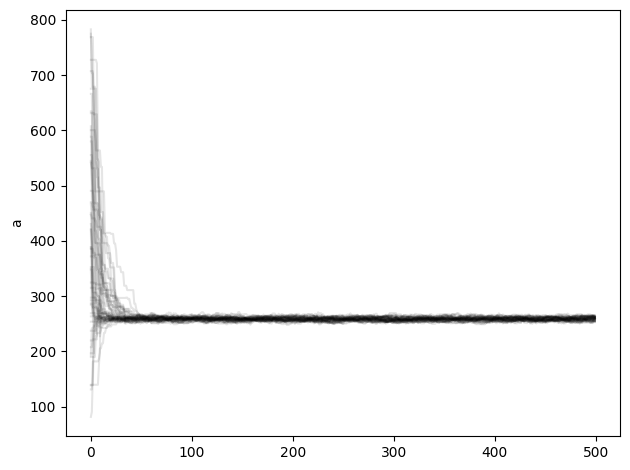

In [33]:
n_walkers = 50
n_dim = 1
n_steps = 500

a_min = 0.0
a_max = 800.0

# set the parameter's initial positions
a_initial = np.random.uniform(a_min, a_max, size=n_walkers)

# take the initial values for each parameter and put them in columns of a 2D array
p0 = np.array([a_initial]).T

sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, 
                                log_prob_fn=ln_posterior, args=[sample_1],
#                                 moves=emcee.moves.GaussianMove(30.0),
                                )
result = sampler.run_mcmc(p0, nsteps=n_steps, progress=True)

plt.figure()
for param_i in range(n_dim):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel("a" if param_i == 0 else "b")
    for j in range(n_walkers):
        chain = sampler.chain[j, :, param_i]
        plt.plot(chain, "k-", alpha=0.1)

plt.tight_layout()
plt.show()

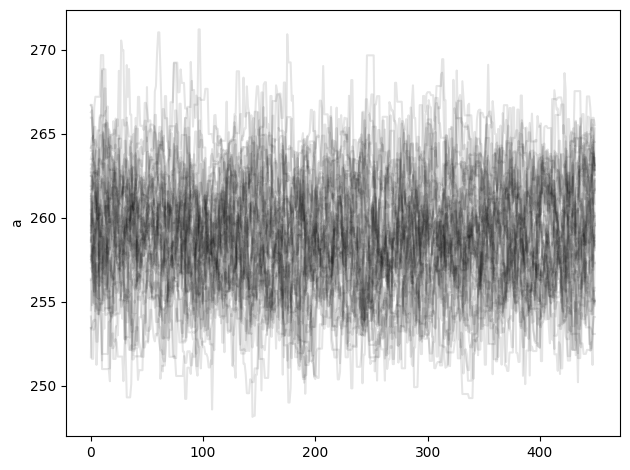

Converged chain shape     : (50, 450, 1)
Converged flatchain shape : (22500, 1)


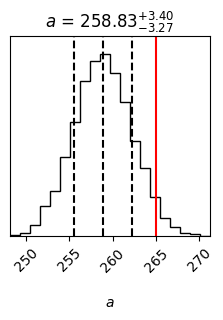

In [34]:
n_burnin = 50

labels = ["a"]
plt.figure()
for param_i in range(n_dim):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel(labels[param_i])
    for j in range(n_walkers):
        chain = sampler.chain[j, n_burnin:, param_i]
        plt.plot(chain, "k-", alpha=0.1)

plt.tight_layout()
plt.show()

converged_chain = sampler.chain[:, n_burnin:, :]
print("Converged chain shape     :", converged_chain.shape)

flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)
print("Converged flatchain shape :", flat_converged_chain.shape)

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[a],
                    truth_color="r",
                    labels=[r"$a$"],
                    show_titles=True
                   )

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">

# Exercise 3: starting from the same position

Run the MCMC analysis with a very narrow range of initial positions (change a_min and a_max).
</div>

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 318.81it/s]


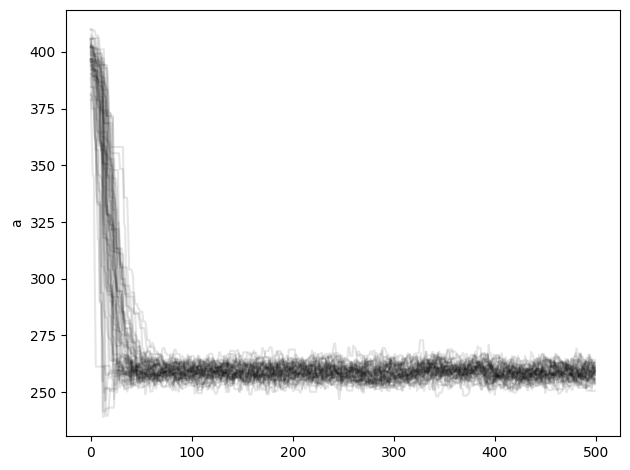

In [39]:
n_walkers = 50
n_dim = 1
n_steps = 500

a_min = 390.0  #change this value
a_max = 410.0  #change this value

# set the parameter's initial positions
a_initial = np.random.uniform(a_min, a_max, size=n_walkers)

# take the initial values for each parameter and put them in columns of a 2D array
p0 = np.array([a_initial]).T

sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, 
                                log_prob_fn=ln_posterior, args=[sample_1],
#                                 moves=emcee.moves.GaussianMove(30.0),
                                )
result = sampler.run_mcmc(p0, nsteps=n_steps, progress=True)

plt.figure()
for param_i in range(n_dim):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel("a" if param_i == 0 else "b")
    for j in range(n_walkers):
        chain = sampler.chain[j, :, param_i]
        plt.plot(chain, "k-", alpha=0.1)

plt.tight_layout()
plt.show()

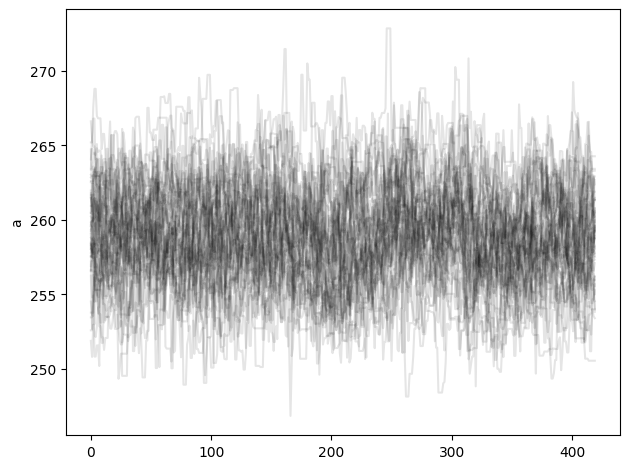

Converged chain shape     : (50, 420, 1)
Converged flatchain shape : (21000, 1)


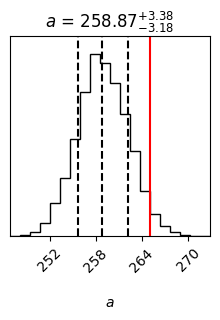

In [40]:
n_burnin = 80

labels = ["a"]
plt.figure()
for param_i in range(n_dim):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel(labels[param_i])
    for j in range(n_walkers):
        chain = sampler.chain[j, n_burnin:, param_i]
        plt.plot(chain, "k-", alpha=0.1)

plt.tight_layout()
plt.show()

converged_chain = sampler.chain[:, n_burnin:, :]
print("Converged chain shape     :", converged_chain.shape)

flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)
print("Converged flatchain shape :", flat_converged_chain.shape)

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[a],
                    truth_color="r",
                    labels=[r"$a$"],
                    show_titles=True
                   )

<font size=3><u>**Compare all the chains and the time needed by the Gaussian and Stretch steps. What are the advantages of using the *stretch* step?**</u><font>

<div class="alert alert-danger" role="alert" style="border-radius: 8px; padding: 10px;">
<details>

<b><summary>[Spoiler] (click here to expand)</summary></b>  

    
    1. Using the stretch move takes a little bit longer, but the convergence is so fast that we can save time by reducing the number of steps.
    
    2. Having said that, with the stretch move we can reach to same number of samples in the same computation time with more walkers, ensuring better exploration of the parameter space.
    
    3. Even if we start from the same, effectively, position, the stretch move is able to move and expand the search.
    
    4. More importantly, with the stretch move we do not need to find the optimal step size!

</details>
</div>

# 5.1. For advanced users...

In the case of non-linear models, and with many dimensions, MCMC is harder to converge. The number of walkers, and step might need to be adapted.

### Increase the **number of walkers**... 

...to explore the parameter space faster in the beginning!

### Increase the **number of steps**...

...to get a better chance for convergence. Fortunately, with `emcee` it is possible to run more steps at will! For example, for the fitting in Kouroumpatzakis et al. 2020 (https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.5967K/abstract), and the user was asked if they want to continue or stop after a given number of steps (or convergence being detected automatically).

# 5.2. Let's try a more difficult model...

The kick velocities NS receive are a reason to change the orbits in binary systems, either disrupting them completely, or inducing an eccentricity. Studies have shown that NS in many binaries have not received significant kick. This gave rise to the *Electron-Capture Supernova* (ECSN) mechanism which makes SN explosions symmetric and therefore, low in kick velocities (e.g, Dessart et al. 2006, ApJ, 644, 1063).

The existence of a population of NSs that have experienced an ECSN would have the effect of an additional Maxwellian component with lower velocities. Let's see that...

Therefore, we need **three parameters** to describe the overall distribution:

* The scale of the less energetic ECSN kick velocity distribution
* The scale of the normal, core-collapse supernova (CCSN) kick velocity distribution
* The fraction of NSs that experienced ECSN (adjusting the relative contribution of the two components)

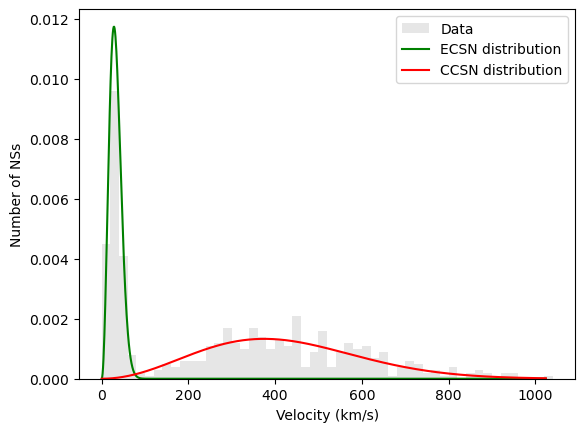

In [19]:
a1_true = 20.0
a2_true = 265.0
f_true = 0.4
N = 500
sample_2 = make_velocity_sample(a1_true, a2_true, f_true, N)

v_step = 20.0
v_bins = np.arange(0.0, max(sample_2)+v_step, v_step)
v_plot = np.linspace(0.0, max(sample_2), 1000)
normalization = 1 # N * v_step
plt.figure()
plt.hist(sample_2, bins=v_bins, color="0.9", ec="0.5", label="Data", density=True)
plt.plot(v_plot, normalization * f_true * st.maxwell(scale=a1_true).pdf(v_plot), "g-", label="ECSN distribution")
plt.plot(v_plot, normalization * (1.0 - f_true) * st.maxwell(scale=a2_true).pdf(v_plot), "r-", label="CCSN distribution")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Number of NSs")
plt.legend(loc="upper right")
plt.show()

In [20]:
def ln_prior_a1(a1):
    return -np.inf if a1 <= 0 else 0.0

def ln_prior_a2(a2):
    return -np.inf if a2 <= 0 else 0.0

def ln_prior_f(f):
    return -np.inf if f < 0 or f > 1 else 0.0

def ln_prior(a1, a2, f):
    return ln_prior_a1(a1) + ln_prior_a2(a2) + ln_prior_f(f)

def datum_ln_likelihood(v, a1, a2, f):
    return np.log(f * st.maxwell.pdf(v, scale=a1) + (1.0 - f) * st.maxwell.pdf(v, scale=a2))

def ln_likelihood(velocities, a1, a2, f):
    return np.sum(datum_ln_likelihood(velocities, a1, a2, f))

def ln_posterior(parameters, velocities):
    a1, a2, f = parameters
    result = ln_prior(a1, a2, f) + ln_likelihood(velocities, a1, a2, f)
    return -np.inf if np.isnan(result) else result

In [ ]:
n_walkers = 100
n_dim = 3
n_steps = 400

# set the parameter
a1_positions = np.random.uniform(0.0, 400.0, size=n_walkers) #Draw samples from a uniform distribution.
a2_positions = np.random.uniform(0.0, 400.0, size=n_walkers)
f_positions = np.random.uniform(0.0, 1.0, size=n_walkers)

# take the initial values for each parameter and put them in columns of a 2D array
positions = np.array([a1_positions, a2_positions, f_positions]).T

sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, log_prob_fn=ln_posterior, args=[sample_2])

In [ ]:
result = sampler.run_mcmc(positions, nsteps=n_steps, progress=True)

In [ ]:
plt.figure()

labels = ["a1", "a2", "f"]

for param_i, label_i in zip(range(n_dim), labels):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel(label_i)
    for j in range(n_walkers):
        chain = sampler.chain[j, :, param_i]
        plt.plot(chain, "k-", alpha=0.1)
plt.tight_layout()
plt.show()

In [ ]:
n_burnin = 100

for param_i, label_i in zip(range(n_dim), labels):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel(label_i)
    for j in range(n_walkers):
        chain = sampler.chain[j, n_burnin:, param_i]
        plt.plot(chain, "k-", alpha=0.1)
plt.tight_layout()
plt.show()

In [ ]:
converged_chain = sampler.chain[:, n_burnin:, :]
print("Converged chain shape     :", converged_chain.shape)

flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)
print("Converged flatchain shape :", flat_converged_chain.shape)

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[a1_true, a2_true, f_true],
                    truth_color="r",
                    labels=[r"$a_1$", r"$a_2$", r"$f$"],
                    show_titles=True, 
#                     range=[0.95]*3,
                   )

<font size=3><u>**What is the problem with this solution? Can we do something about it?**</u><font>

<div class="alert alert-danger" role="alert" style="border-radius: 8px; padding: 10px;">
<details>

<b><summary>[Spoiler] (click here to expand)</summary></b>  
<br>
    There is a degeneracy in the parameters: $a_1$ and $a_2$ can be exchanged, and the fraction $f$ can be for either of the two populations! The peaks we detect are not representative of the final distributions!
<br>    
    This leads to an unwanted solution, and the walkers spending too much time moving back and forth.
<br>    
    We can break the symmetry by requirying that $a_1 < a_2$. This will happen in the prior!
</details>
</div>

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">

# Exercise 4: enforce a single solution
</div>

In [ ]:
def ln_prior_a1(a1):
    return -np.inf if a1 <= 0 else 0.0

def ln_prior_a2(a2):
    return -np.inf if a2 <= 0 else 0.0

def ln_prior_f(f):
    return -np.inf if f < 0 or f > 1 else 0.0

def ln_prior(a1, a2, f):
    return ln_prior_a1(a1) + ln_prior_a2(a2) + ln_prior_f(f)

def datum_ln_likelihood(v, a1, a2, f):
    return np.log(f * st.maxwell.pdf(v, scale=a1) + (1.0 - f) * st.maxwell.pdf(v, scale=a2))

def ln_likelihood(velocities, a1, a2, f):
    return np.sum(datum_ln_likelihood(velocities, a1, a2, f))

def ln_posterior(parameters, velocities):
    a1, a2, f = parameters
    result = ln_prior(a1, a2, f) + ln_likelihood(velocities, a1, a2, f)
    return -np.inf if np.isnan(result) else result

n_walkers = 100
n_dim = 3
n_steps = 400

# set the parameter
a1_positions = np.random.uniform(100.0, 400.0, size=n_walkers)
a2_positions = np.random.uniform(100.0, 400.0, size=n_walkers)
f_positions = np.random.uniform(0.0, 1.0, size=n_walkers)

# take the initial values for each parameter and put them in columns of a 2D array
positions = np.array([a1_positions, a2_positions, f_positions]).T

sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, log_prob_fn=ln_posterior, args=[sample_2])

In [ ]:
result = sampler.run_mcmc(positions, nsteps=n_steps, progress=True)

In [ ]:
plt.figure()

labels = ["a1", "a2", "f"]

for param_i, label_i in zip(range(n_dim), labels):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel(label_i)
    for j in range(n_walkers):
        chain = sampler.chain[j, :, param_i]
        plt.plot(chain, "k-", alpha=0.1)
plt.tight_layout()
plt.show()

In [ ]:
n_burnin = 90

for param_i, label_i in zip(range(n_dim), labels):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel(label_i)
    for j in range(n_walkers):
        chain = sampler.chain[j, n_burnin:, param_i]
        plt.plot(chain, "k-", alpha=0.1)
plt.tight_layout()
plt.show()

**What do you notice about the burn-in phase?**

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">

# Exercise 5: try again with $a_1 = a_2$
* You can somehow see a slight preference of using only one component (the peaks at 0 and 1 in the f distribution).
* Also, when the f is 0 or 1, you see that a2 and a1 are better constrained respectively (you don't care of the parameter of a component that doesn't participate at all in the likelihood).
* when f is not extreme, a1 and a2 take more or less the same value... to create an up-scaled version of the original distribution!
</div>

In [ ]:
a1_true = 265.0
a2_true = 265.0
f_true = 0.4
N = 500
sample_3 = make_velocity_sample(a1_true, a2_true, f_true, N)

v_step = 20.0
v_bins = np.arange(0.0, max(sample_3)+v_step, v_step)
v_plot = np.linspace(0.0, max(sample_3), 1000)
normalization = 1 # N * v_step
plt.figure()
plt.hist(sample_3, bins=v_bins, color="0.9", ec="0.5", label="Data", density=True)
plt.plot(v_plot, normalization * f_true * st.maxwell(scale=a1_true).pdf(v_plot), "g-", label="ECSN distribution")
plt.plot(v_plot, normalization * (1.0 - f_true) * st.maxwell(scale=a2_true).pdf(v_plot), "r-", label="CCSN distribution")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Number of NSs")
plt.legend(loc="upper right")
plt.show()

In [ ]:
def ln_prior_a1(a1):
    return -np.inf if a1 <= 0 else 0.0

def ln_prior_a2(a2):
    return -np.inf if a2 <= 0 else 0.0

def ln_prior_f(f):
    return -np.inf if f < 0 or f > 1 else 0.0

def ln_prior(a1, a2, f):
    if a1 > a2:
        return -np.inf
    return ln_prior_a1(a1) + ln_prior_a2(a2) + ln_prior_f(f)

def datum_ln_likelihood(v, a1, a2, f):
    return np.log(f * st.maxwell.pdf(v, scale=a1) + (1.0 - f) * st.maxwell.pdf(v, scale=a2))

def ln_likelihood(velocities, a1, a2, f):
    return np.sum(datum_ln_likelihood(velocities, a1, a2, f))

def ln_posterior(parameters, velocities):
    a1, a2, f = parameters
    result = ln_prior(a1, a2, f) + ln_likelihood(velocities, a1, a2, f)
    return -np.inf if np.isnan(result) else result


n_walkers = 100
n_dim = 3
n_steps = 400

# set the parameter
a1_positions = np.random.uniform(100.0, 400.0, size=n_walkers)
a2_positions = np.random.uniform(100.0, 400.0, size=n_walkers)
f_positions = np.random.uniform(0.0, 1.0, size=n_walkers)

# take the initial values for each parameter and put them in columns of a 2D array
positions = np.array([a1_positions, a2_positions, f_positions]).T


sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, log_prob_fn=ln_posterior, args=[sample_3])
result = sampler.run_mcmc(positions, nsteps=n_steps, progress=True)

In [ ]:
plt.figure()

labels = ["a1", "a2", "f"]

for param_i, label_i in zip(range(n_dim), labels):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel(label_i)
    for j in range(n_walkers):
        chain = sampler.chain[j, :, param_i]
        plt.plot(chain, "k-", alpha=0.1)
plt.tight_layout()
plt.show()

In [ ]:
n_burnin = 50

for param_i, label_i in zip(range(n_dim), labels):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel(label_i)
    for j in range(n_walkers):
        chain = sampler.chain[j, n_burnin:, param_i]
        plt.plot(chain, "k-", alpha=0.1)
plt.tight_layout()
plt.show()

In [ ]:
converged_chain = sampler.chain[:, n_burnin:, :]
print("Converged chain shape     :", converged_chain.shape)

flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)
print("Converged flatchain shape :", flat_converged_chain.shape)

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[a1_true, a2_true, f_true],
                    truth_color="r",
                    labels=[r"$a_1$", r"$a_2$", r"$f$"],
                    show_titles=True, 
                    range=[0.95]*3,
                   )

<font size=3><u>**Explain the structures in the corner plot**</u><font>

<div class="alert alert-danger" role="alert" style="border-radius: 8px; padding: 10px;">
<details>

<b><summary>[Spoiler] (click here to expand)</summary></b>  
    When $a_1 = a_2$ the fraction parameter is unconstrained because it lacks meaning! However, then the fraction is 0 or 1, then the contribution of one component is minimal, and therefore, its scale is unconstrained. On the other hand, for intermediate values, the two scales converge to the correct value. The "angle" in the $a_1$-$a_2$ plot is created by the inequality enforced by the prior.
</details>
</div>

## References

[1]. Wikipedia contributors. (2019, May 9). Test functions for optimization. In Wikipedia, The Free Encyclopedia. Retrieved 20:20, June 12, 2019, from https://en.wikipedia.org/w/index.php?title=Test_functions_for_optimization&oldid=896257708

[2]. Lee, Jaewook & Sung, Woosuk & Choi, Joo-Ho. (2015). Metamodel for Efficient Estimation of Capacity-Fade Uncertainty in Li-Ion Batteries for Electric Vehicles. Energies. 8. 5538-5554. 10.3390/en8065538.

[3]. Foreman-Mackey, D., Hogg, D. W., Lang, D., & Goodman, J. 2013, PASP, 125, 306. https://ui.adsabs.harvard.edu/abs/2013PASP..125..306F/abstract

[4]. Kouroumpatzakis et al. (2020), MNRAS, 494, 5967. https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.5967K/abstract

[5]. Hobbs et al. (2005), MNRAS, 360, 974. https://ui.adsabs.harvard.edu/abs/2005MNRAS.360..974H/abstract

[6]. Dessart et al. (2006), ApJ, 644, 1063. https://ui.adsabs.harvard.edu/abs/2006ApJ...644.1063D/abstract